In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torchvision.utils as vutils

import os
import json
import numpy as np
import csv
import pandas as pd
import math
import numpy as np
import glob
import tqdm
import sys
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from tqdm import tqdm
import sklearn
from sklearn.metrics import accuracy_score

import seaborn as sns
sns.set_theme(style="ticks")

import torchvision
from torchvision.io import read_image

# from sdtw_cuda_loss import SoftDTW

In [3]:
# %load_ext tensorboard
# from torch.utils.tensorboard import SummaryWriter

In [4]:
device = torch.device('cuda:1') #  if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=1)

In [5]:
# target_folder = './extracted/mwd/nopims/'
target_folder = '/home/sharifullina/thesis/TIME/extracted/mwd/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/nopims/'

### Выгрузим датасет Volve и преобразуем данные

In [6]:
wells = os.listdir(target_folder)
required_params_plus = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA', 'WELL']
required_params = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA']

logs = [json.load(open(os.path.join(target_folder, wells[i]), 'r')) for i in range(len(wells))]

In [7]:
# X_all - Dataframe with all logging while drilling data concatenated

dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
for i in range(len(dataset_all)):
    dataset_all[i]['WELL'] = wells[i]

dataset = []
for df in dataset_all:
    dataset.append(df[required_params_plus])
    
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

# X_list is a list containing a data for all wells splitted to windows with size 256

X_list = []
for i in range(0, len(X_all) - 256, 10):
    X_list.append(X_all[i : 256 + i])

    
# X_list_minus is X_list but without the WELL column
    
X_list_minus = []
for x in X_list:
    X_list_minus.append(x.loc[:, x.columns != 'WELL'])

X_verif_list = X_list_minus
    
# X is an array with the shape = (5901, 256, 5)
    
X = []
for i in X_list_minus:
    X.append(i.values)

X = np.dstack(X)
X = np.rollaxis(X, -1)

# map_well_to_label is dictionary to help to rename wells from 'well_N' to N
map_well_to_label = {w:i for i, w in enumerate(wells)}

# label = well's number
y = np.array([map_well_to_label[df['WELL'].iloc[0]] for df in X_list])


### Импортируем verificator, regulator

In [8]:
from dataset import *
from model import * # GAN model
from inceptiontime.src.models.inception import InceptionModel # Verificator
# Regulator
from time_series_metrics.ssim_loss import SSIM_1d_conv
# from time_series_metrics.tsfresh_metrics import tsfresh_metrics
from time_series_metrics.tsfresh_loss import Mean_similarity_loss, Root_mean_square_similarity_loss, Coisine_between_angles_loss, Pearson_corr_funct_loss, Eucledian_distance_loss


### Загрузим датасет

In [9]:
torch_dataset = DataSet(X, y, sparse_rate=1)
all_loader = DataLoader(torch_dataset, batch_size=64, shuffle=True)

In [10]:
train_n = 5310
train_set, val_set = torch.utils.data.random_split(torch_dataset, [train_n, len(torch_dataset) - train_n])

In [11]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

### создадим датасет для верификатора

In [12]:
# соеденим все логи скважин в один большой pandas.DaraFrame
dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
dataset = []
for df in dataset_all:
    dataset.append(df[required_params])
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

In [13]:
similar_wells = []

for i in range(0, 18400, 20):
    similar_wells.append(X_all[i : 256 + i])
# преобразуем лист в массив с размерностью [20, 256, 5]; 20 - количество скважин, 256 - размерность окна, 
#                                                   5 - количество столбцов = len(required_params)
similar_wells = np.dstack(similar_wells)
similar_wells = np.rollaxis(similar_wells, -1)
similar_wells.shape

(920, 256, 5)

In [14]:
different_wells = []

for i in range(0, 256 * 230, 256):
    different_wells.append(X_all[i : 256 + i])
    different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(),\
                                                                 X_all[i : 256 + i].std(), [256, 5]))
    different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(), \
                                                                 X_all[i : 256 + i].std(), [256, 5]))
    different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(),\
                                                                 X_all[i : 256 + i].std(), [256, 5]))
    
different_wells = np.dstack(different_wells)
different_wells = np.rollaxis(different_wells, -1)


In [15]:
needed = []
for i in range(different_wells.shape[0]):
    needed.append([different_wells[i - 1], different_wells[i], 1])
    needed.append([similar_wells[i - 1], similar_wells[i], 0])

In [16]:
# with open('some.csv', 'w') as f:
#     writer = csv.writer(f)
#     writer.writerow(['time1', 'time2', 'relationshion'])
#     writer.writerows(needed)

In [17]:
# df = pd.read_csv('some.csv')
# df = df.sample(frac=1)
# df.head()

In [18]:
from torch.utils.data import Dataset

class Verification(Dataset):
    def __init__(self, needed, feature_scales_simil={}, feature_scales_diff={}):
        
        self.needed = needed
        self.feature_scales_simil = feature_scales_simil
        self.feature_scales_diff = feature_scales_diff
        
    def __getitem__(self, index):

        time1 = self.needed[index][0]
        time2 = self.needed[index][1]
        relation = self.needed[index][2]
        
        self.time1 = torch.tensor(time1).to(torch.float32)
        self.time2 = torch.tensor(time2).to(torch.float32)
        self.relation = torch.tensor(relation).to(torch.float32)
        
        # time1
        for f in range(self.time1.shape[1]):
            self.time1[:, f] = self.time1[:, f] - self.time1[:, f].mean()
            
        for f in range(self.time1.shape[1]):
            if f not in self.feature_scales_simil:
                std = self.time1[:, f].std()
                self.feature_scales_simil[f] = std
            self.time1[:, f] = self.time1[:, f] / self.feature_scales_simil[f]
            
        # time2
        for f in range(self.time2.shape[1]):
            self.time2[:, f] = self.time2[:, f] - self.time2[:, f].mean()
            
        for f in range(self.time2.shape[1]):
            if f not in self.feature_scales_diff:
                std = self.time2[:, f].std()
                self.feature_scales_diff[f] = std
            self.time2[:, f] = self.time2[:, f] / self.feature_scales_diff[f]
            
        self.time1 = self.time1.transpose(0, 1)
        self.time2 = self.time2.transpose(0, 1)

        return self.time1, self.time2, self.relation

    def __len__(self):
        return len(self.needed)
    

In [19]:
verif_dataset = Verification(needed)
verif_loader = DataLoader(verif_dataset, batch_size=64, shuffle=True)

In [20]:
# test
for time1, time2, label in verif_loader:
    print(time1.shape)
    print(time2.shape)
    print(label)
    break

torch.Size([64, 5, 256])
torch.Size([64, 5, 256])
tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 1.])


### Train verification model

In [21]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                       out_channels=30,
                       bottleneck_channels=12, kernel_sizes=15,
                       use_residuals=True, 
                       num_pred_classes=len(wells)).to(device)

optimizer_verification = torch.optim.Adam(model_verification.parameters(), lr=1e-3)

In [22]:
class VerificationLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(VerificationLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = (1-label) * torch.pow(euclidean_distance, 2)
        neg = (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss_contrastive = torch.mean( pos + neg )
        return loss_contrastive

criterion_verification = VerificationLoss()

In [23]:
# best_train_acc = 0
# train_loss = []
# train_acc = []
# num_epochs = 100
# patience_counter = 0
# best_state_dict = None

# for epoch in range(num_epochs):
#     model_verification.train();
#     epoch_train_loss = []
#     all_preds = []
#     all_y = []
#     for time1, time2, label in verif_loader:
#         time1 = time1.to(device)
#         time2 = time2.to(device)
#         label = label.to(device)
#         optimizer_verification.zero_grad()
#         encoded_1 = model_verification(time1) 
#         encoded_2 = model_verification(time2)
#         loss = criterion_verification(encoded_1, encoded_2, label)
#         epoch_train_loss.append(loss.item())
#         loss.backward()
#         optimizer_verification.step()
#     if epoch % 10 == 0:
#         print(f"Epoch [{epoch}/{num_epochs}] Loss V: {loss.item():.4f}")
#     train_loss.append(np.mean(epoch_train_loss))


# plt.plot(train_loss, label = 'train loss')
# plt.legend()
# plt.grid()
# plt.title('Mean loss inception score')
# plt.show()

# torch.save({
#     'model_state_dict': model_verification.state_dict(),
# }, 
#     'trained_models/model_verification.pt'
# )

In [24]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                                    out_channels=30,
                                    bottleneck_channels=12, kernel_sizes=15,
                                    use_residuals=True, 
                                    num_pred_classes=len(wells)).to(device)
checkpoint = torch.load('trained_models/model_verification.pt')
model_verification.load_state_dict(checkpoint['model_state_dict'])
# model_verification.eval()

<All keys matched successfully>

### Training models

In [25]:
# GANs hyperparamters
lr = 3e-4
batch_size = 128
num_epochs = 100
n_noise = 256
n_critic = 1
fixed_noise = torch.randn((batch_size, len(required_params), 256)).to(device)

In [26]:
disc_ms = Discriminator().to(device)
gen_ms = Generator().to(device)

disc_rms = Discriminator().to(device)
gen_rms = Generator().to(device)

disc_cba = Discriminator().to(device)
gen_cba = Generator().to(device)

disc_pcf = Discriminator().to(device)
gen_pcf = Generator().to(device)

disc_ed = Discriminator().to(device)
gen_ed = Generator().to(device)

disc_ssim = Discriminator().to(device)
gen_ssim = Generator().to(device)

criterion_gan_ms = nn.BCELoss()
criterion_gan_rms = nn.BCELoss()
criterion_gan_cba = nn.BCELoss()
criterion_gan_pcf = nn.BCELoss()
criterion_gan_ed = nn.BCELoss()
criterion_gan_ssim = nn.BCELoss()

D_opt_ms = torch.optim.Adam(disc_ms.parameters(), lr = lr)
G_opt_ms = torch.optim.Adam(gen_ms.parameters(), lr = lr)

D_opt_rms = torch.optim.Adam(disc_rms.parameters(), lr = lr)
G_opt_rms = torch.optim.Adam(gen_rms.parameters(), lr = lr)

D_opt_cba = torch.optim.Adam(disc_cba.parameters(), lr = lr)
G_opt_cba = torch.optim.Adam(gen_cba.parameters(), lr = lr)

D_opt_pcf = torch.optim.Adam(disc_pcf.parameters(), lr = lr)
G_opt_pcf = torch.optim.Adam(gen_pcf.parameters(), lr = lr)

D_opt_ed = torch.optim.Adam(disc_ed.parameters(), lr = lr)
G_opt_ed = torch.optim.Adam(gen_ed.parameters(), lr = lr)

D_opt_ssim = torch.optim.Adam(disc_ssim.parameters(), lr = lr)
G_opt_ssim = torch.optim.Adam(gen_ssim.parameters(), lr = lr)

In [27]:
# print('Discriminator paramteres:', sum(p.numel() for p in disc_mean_similarity.parameters() if p.requires_grad))
# print('Generator paramteres:', sum(p.numel() for p in gen_mean_similarity.parameters() if p.requires_grad))

In [28]:
# writer_fake = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_time_series/fake")
# writer_real = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_time_series/real")

### training the model

In [30]:
############################ CHECK ############################


# disc = Discriminator().to(device)
# gen = Generator().to(device)
# criterion_gan = nn.BCELoss()
# D_opt = torch.optim.Adam(disc.parameters(), lr = lr)
# G_opt = torch.optim.Adam(gen.parameters(), lr = lr)

# v_l = []
# fake_l = []
# real_l = []

# for idx, data_all in enumerate(train_loader):
#     # data preprocessing
#     step = 0
#     real_data, y = data_all
#     real_data, y = real_data.to(device), y.to(device)
#     batch_size = real_data.size(0)

#     # DISCRIMINATOR TRAINING == maximize D(real_data) + (1 - D(G(noise)))
#     gen.eval()
#     disc.train()
#     D_opt.zero_grad()

#     fake = gen(real_data)
#     disc_real = disc(real_data)        
#     D_loss_1 = criterion_gan(disc_real, torch.ones_like(disc_real))
#     disc_fake = disc(fake)
#     D_loss_2 = criterion_gan(disc_fake, torch.zeros_like(disc_fake))

#     # verificator loss
#     model_verification.eval()
#     embeding_fake = model_verification(fake)
#     embeding_real = model_verification(real_data)
#     a = torch.tensor([embeding_fake[i, y[i] - 1].item() for i in range(len(y))]).to(device)
#     b = torch.max(embeding_fake, dim = 1)[0]
#     print(torch.tensor([embeding_fake[i, y[i] - 1].item() for i in range(len(y))]))
#     print(torch.max(embeding_fake, dim = 1)[0])
#     print((a < b).float().mean())
#     break

In [31]:
def train(loader, 
          gen, 
          disc, 
          criterion_gan, 
          G_opt, 
          D_opt, 
          model_verification, 
          criterion_verification, 
          criterion_regulator,
          save_PATH, 
          lr, batch_size, num_epochs, n_noise, n_critic):
    
    de_ident_rate_list = []
    simil_index = 0

    G_losses = []
    D_losses = []
    R_losses = []
    V_losses = []
    V_losses2 = []
    verificator_labels = []
    verificator_preds = []

    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        for idx, data_all in enumerate(loader):
            # data preprocessing
            step = 0
            real_data, y = data_all
            real_data, y = real_data.to(device), y.to(device)
            batch_size = real_data.size(0)

            # DISCRIMINATOR TRAINING == maximize D(real_data) + (1 - D(G(noise)))
            gen.eval()
            disc.train()
            D_opt.zero_grad()

            fake = gen(real_data)
            disc_real = disc(real_data)        
            D_loss_1 = criterion_gan(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake)
            D_loss_2 = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
            
            # verificator loss
            model_verification.eval()
            embeding_fake = model_verification(fake)
            embeding_real = model_verification(real_data)
            label = torch.ones(batch_size).to(device)
            loss_verif = criterion_verification(embeding_real, embeding_fake, label)
            V_losses.append(loss_verif.item())
            
            # de-identification rate
            pred_equal_y = torch.tensor([embeding_fake[i, y[i] - 1].item() for i in range(len(y))]).to(device)
            pred_max = torch.max(embeding_fake, dim = 1)[0]
            de_ident_rate_list.append((pred_equal_y < pred_max).float().mean())
            
            # similarity loss
            if criterion_regulator != Eucledian_distance_loss:
                loss_regul = criterion_regulator()(real_data, fake)
            else:
                loss_regul = criterion_regulator()(real_data, fake) / 1000
            R_losses.append(loss_regul.item())
            
            D_loss = (D_loss_1 + D_loss_2) / 2 + loss_verif.detach() + loss_regul.detach()
            D_losses.append(D_loss.item())
            D_loss.backward() # retain_graph = True
            D_opt.step()
            
            # GENERATOR TRAINING == maximize D(G(noise))
            gen.train()
            disc.eval()
            G_opt.zero_grad()

            fake = gen(real_data)
            output = disc(fake)
            G_loss = criterion_gan(output, torch.ones_like(output))
            G_losses.append(G_loss.item())
            G_loss.backward() 
            G_opt.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(loader)} Loss D: {D_loss.item():.4f}, Loss G: {G_loss.item():.4f}, Loss V: {loss_verif.item():.4f}, Loss R: {loss_regul.item():.4f}")


            step += 1
            
    de_ident_rate = (sum(de_ident_rate_list) / len(de_ident_rate_list)).item()
    str_simil = 1 - sum(R_losses) / len(R_losses)
                    
    torch.save({
        'gen_state_dict': gen.state_dict(),
        'disc_state_dict': disc.state_dict(),
        'de_ident_rate': de_ident_rate,
        'str_simil': str_simil
    }, save_PATH)
    
    return G_losses, D_losses, R_losses, V_losses, V_losses2

---

### models training

In [32]:
losses_ms = train(loader = train_loader, 
                  gen = gen_ms, 
                  disc = disc_ms, 
                  criterion_gan = criterion_gan_ms, 
                  G_opt = G_opt_ms, 
                  D_opt = D_opt_ms, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Mean_similarity_loss,
                  save_PATH = 'trained_models/gan_ms.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 0.9525, Loss G: 0.3144, Loss V: 0.6226, Loss R: 0.2509
Epoch [10/100] Batch 82/83 Loss D: 1.2976, Loss G: 0.0131, Loss V: 1.0718, Loss R: 0.2248
Epoch [20/100] Batch 82/83 Loss D: 0.4410, Loss G: 0.0014, Loss V: 0.2221, Loss R: 0.2188
Epoch [30/100] Batch 82/83 Loss D: 0.2266, Loss G: 0.0015, Loss V: 0.0073, Loss R: 0.2192
Epoch [40/100] Batch 82/83 Loss D: 0.8766, Loss G: 0.0054, Loss V: 0.6701, Loss R: 0.2064
Epoch [50/100] Batch 82/83 Loss D: 0.3569, Loss G: 0.0007, Loss V: 0.1431, Loss R: 0.2137
Epoch [60/100] Batch 82/83 Loss D: 0.2140, Loss G: 0.0003, Loss V: 0.0000, Loss R: 0.2139
Epoch [70/100] Batch 82/83 Loss D: 0.2087, Loss G: 0.0000, Loss V: 0.0011, Loss R: 0.2076
Epoch [80/100] Batch 82/83 Loss D: 0.2157, Loss G: 0.0002, Loss V: 0.0102, Loss R: 0.2054
Epoch [90/100] Batch 82/83 Loss D: 0.2074, Loss G: 0.0003, Loss V: 0.0000, Loss R: 0.2074


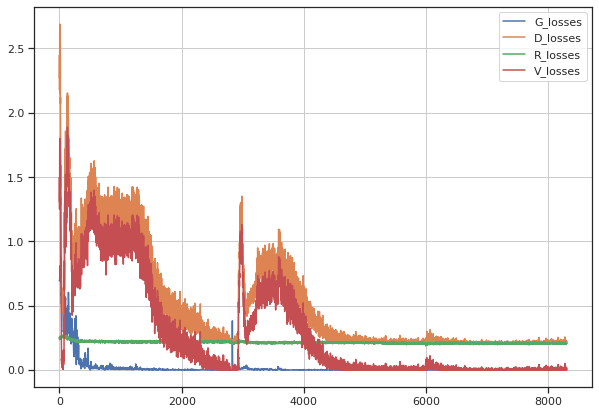

In [34]:
plt.figure(figsize=(10, 7))
plt.plot(losses_ms[0], label = 'G_losses')
plt.plot(losses_ms[1], label = 'D_losses')
plt.plot(losses_ms[2], label = 'R_losses')
plt.plot(losses_ms[3], label = 'V_losses')
plt.legend()
plt.grid()
plt.show()

In [36]:
gen_ms = Generator().to(device)
disc_ms = Discriminator().to(device)

checkpoint_ms = torch.load('trained_models/gan_ms.pt')

gen_ms.load_state_dict(checkpoint_ms['gen_state_dict'])
disc_ms.load_state_dict(checkpoint_ms['disc_state_dict'])
de_ident_rate_ms = checkpoint_ms['de_ident_rate']
str_simil_ms = checkpoint_ms['str_simil']
print(de_ident_rate_ms)
print(str_simil_ms)
# gen_ms.eval()

0.963003396987915
0.7860026781045528


### root_mean_square

In [37]:
losses_rms = train(loader = train_loader, 
                  gen = gen_rms, 
                  disc = disc_rms, 
                  criterion_gan = criterion_gan_rms, 
                  G_opt = G_opt_rms, 
                  D_opt = D_opt_rms, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Root_mean_square_similarity_loss,
                  save_PATH = 'trained_models/gan_rms.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 1.2381, Loss G: 0.3508, Loss V: 0.7464, Loss R: 0.4124
Epoch [10/100] Batch 82/83 Loss D: 0.3932, Loss G: 0.0646, Loss V: 0.0021, Loss R: 0.3905
Epoch [20/100] Batch 82/83 Loss D: 0.3807, Loss G: 0.0198, Loss V: 0.0000, Loss R: 0.3797
Epoch [30/100] Batch 82/83 Loss D: 0.3661, Loss G: 0.0016, Loss V: 0.0018, Loss R: 0.3642
Epoch [40/100] Batch 82/83 Loss D: 0.3825, Loss G: 0.0008, Loss V: 0.0051, Loss R: 0.3772
Epoch [50/100] Batch 82/83 Loss D: 0.3574, Loss G: 0.0251, Loss V: 0.0000, Loss R: 0.3571
Epoch [60/100] Batch 82/83 Loss D: 0.3396, Loss G: 0.0094, Loss V: 0.0000, Loss R: 0.3396
Epoch [70/100] Batch 82/83 Loss D: 0.3299, Loss G: 0.0063, Loss V: 0.0000, Loss R: 0.3298
Epoch [80/100] Batch 82/83 Loss D: 0.3538, Loss G: 0.0038, Loss V: 0.0000, Loss R: 0.3538
Epoch [90/100] Batch 82/83 Loss D: 0.3514, Loss G: 0.0033, Loss V: 0.0000, Loss R: 0.3514


In [38]:
gen_rms = Generator().to(device)
disc_rms = Discriminator().to(device)

checkpoint_rms = torch.load('trained_models/gan_rms.pt')

gen_rms.load_state_dict(checkpoint_rms['gen_state_dict'])
disc_rms.load_state_dict(checkpoint_rms['disc_state_dict'])
de_ident_rate_rms = checkpoint_rms['de_ident_rate']
str_simil_rms = checkpoint_rms['str_simil']

# gen_rms.eval()

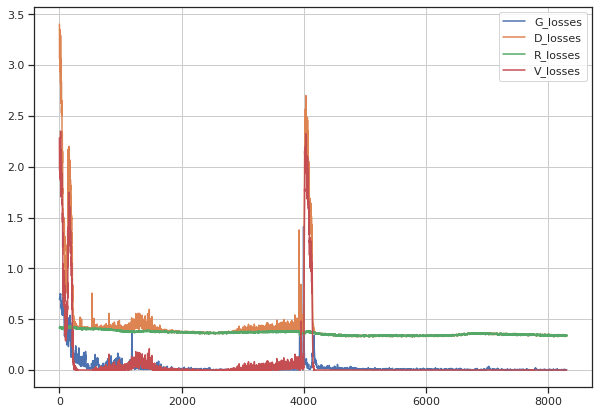

In [39]:
plt.figure(figsize=(10, 7))
plt.plot(losses_rms[0], label = 'G_losses')
plt.plot(losses_rms[1], label = 'D_losses')
plt.plot(losses_rms[2], label = 'R_losses')
plt.plot(losses_rms[3], label = 'V_losses')
plt.legend()
plt.grid()
plt.show()

### coisine_between_angles

In [40]:
losses_cba = train(loader = train_loader, 
                  gen = gen_cba, 
                  disc = disc_cba, 
                  criterion_gan = criterion_gan_cba, 
                  G_opt = G_opt_cba, 
                  D_opt = D_opt_cba, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Coisine_between_angles_loss,
                  save_PATH = 'trained_models/gan_cba.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 0.0950, Loss G: 0.2684, Loss V: 0.0000, Loss R: 0.0026
Epoch [10/100] Batch 82/83 Loss D: 0.9705, Loss G: 0.0018, Loss V: 0.9674, Loss R: 0.0022
Epoch [20/100] Batch 82/83 Loss D: 0.4556, Loss G: 0.0009, Loss V: 0.4568, Loss R: -0.0014
Epoch [30/100] Batch 82/83 Loss D: 0.8049, Loss G: 0.0002, Loss V: 0.8026, Loss R: 0.0023
Epoch [40/100] Batch 82/83 Loss D: 0.8636, Loss G: 0.0004, Loss V: 0.8625, Loss R: 0.0011
Epoch [50/100] Batch 82/83 Loss D: 1.2270, Loss G: 0.0003, Loss V: 1.2202, Loss R: 0.0067
Epoch [60/100] Batch 82/83 Loss D: 0.0220, Loss G: 0.0003, Loss V: 0.0183, Loss R: 0.0036
Epoch [70/100] Batch 82/83 Loss D: 0.0181, Loss G: 0.0001, Loss V: 0.0154, Loss R: 0.0027
Epoch [80/100] Batch 82/83 Loss D: 0.0094, Loss G: 0.0002, Loss V: 0.0053, Loss R: 0.0040
Epoch [90/100] Batch 82/83 Loss D: 0.0100, Loss G: 0.0001, Loss V: 0.0078, Loss R: 0.0022


In [41]:
gen_cba = Generator().to(device)
disc_cba = Discriminator().to(device)

checkpoint_cba = torch.load('trained_models/gan_cba.pt')

gen_cba.load_state_dict(checkpoint_cba['gen_state_dict'])
disc_cba.load_state_dict(checkpoint_cba['disc_state_dict'])
de_ident_rate_cba = checkpoint_cba['de_ident_rate']
str_simil_cba = checkpoint_cba['str_simil']

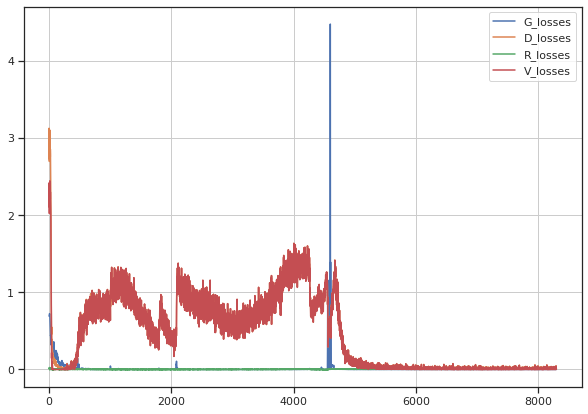

In [42]:
plt.figure(figsize=(10, 7))
plt.plot(losses_cba[0], label = 'G_losses')
plt.plot(losses_cba[1], label = 'D_losses')
plt.plot(losses_cba[2], label = 'R_losses')
plt.plot(losses_cba[3], label = 'V_losses')
plt.legend()
plt.grid()
plt.show()

### pearson_corr_funct

In [43]:
losses_pcf = train(loader = train_loader, 
                  gen = gen_pcf, 
                  disc = disc_pcf, 
                  criterion_gan = criterion_gan_pcf, 
                  G_opt = G_opt_pcf, 
                  D_opt = D_opt_pcf, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Pearson_corr_funct_loss,
                  save_PATH = 'trained_models/gan_pcf.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 1.7558, Loss G: 0.4195, Loss V: 1.6667, Loss R: -0.0025
Epoch [10/100] Batch 82/83 Loss D: 0.6445, Loss G: 0.0391, Loss V: 0.6377, Loss R: 0.0054
Epoch [20/100] Batch 82/83 Loss D: 0.0012, Loss G: 0.0533, Loss V: 0.0000, Loss R: 0.0009
Epoch [30/100] Batch 82/83 Loss D: 0.3466, Loss G: 0.0115, Loss V: 0.3423, Loss R: 0.0042
Epoch [40/100] Batch 82/83 Loss D: 0.2520, Loss G: 0.0151, Loss V: 0.2505, Loss R: 0.0014
Epoch [50/100] Batch 82/83 Loss D: 0.0291, Loss G: 0.0050, Loss V: 0.0305, Loss R: -0.0014
Epoch [60/100] Batch 82/83 Loss D: 0.0070, Loss G: 0.0051, Loss V: 0.0130, Loss R: -0.0060
Epoch [70/100] Batch 82/83 Loss D: 1.1781, Loss G: 0.0043, Loss V: 1.1773, Loss R: 0.0008
Epoch [80/100] Batch 82/83 Loss D: 1.0481, Loss G: 0.0154, Loss V: 1.0528, Loss R: -0.0050
Epoch [90/100] Batch 82/83 Loss D: 0.9678, Loss G: 0.0029, Loss V: 0.9697, Loss R: -0.0020


In [44]:
gen_pcf = Generator().to(device)
disc_pcf = Discriminator().to(device)

checkpoint_pcf = torch.load('trained_models/gan_pcf.pt')

gen_pcf.load_state_dict(checkpoint_pcf['gen_state_dict'])
disc_pcf.load_state_dict(checkpoint_pcf['disc_state_dict'])
de_ident_rate_pcf = checkpoint_pcf['de_ident_rate']
str_simil_pcf = checkpoint_pcf['str_simil']

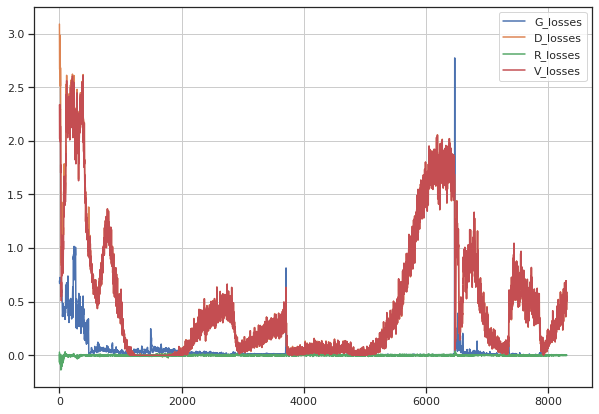

In [45]:
plt.figure(figsize=(10, 7))
plt.plot(losses_pcf[0], label = 'G_losses')
plt.plot(losses_pcf[1], label = 'D_losses')
plt.plot(losses_pcf[2], label = 'R_losses')
plt.plot(losses_pcf[3], label = 'V_losses')
plt.legend()
plt.grid()
plt.show()

### eucledian_distance

In [46]:
losses_ed = train(loader = train_loader, 
                  gen = gen_ed, 
                  disc = disc_ed, 
                  criterion_gan = criterion_gan_ed, 
                  G_opt = G_opt_ed, 
                  D_opt = D_opt_ed, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Eucledian_distance_loss,
                  save_PATH = 'trained_models/gan_ed.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 1.5691, Loss G: 0.5438, Loss V: 1.1980, Loss R: 0.2898
Epoch [10/100] Batch 82/83 Loss D: 0.3008, Loss G: 0.0677, Loss V: 0.0000, Loss R: 0.3002
Epoch [20/100] Batch 82/83 Loss D: 0.4195, Loss G: 0.0416, Loss V: 0.0000, Loss R: 0.4191
Epoch [30/100] Batch 82/83 Loss D: 0.3276, Loss G: 0.0074, Loss V: 0.0019, Loss R: 0.3256
Epoch [40/100] Batch 82/83 Loss D: 0.5098, Loss G: 0.0031, Loss V: 0.0449, Loss R: 0.4648
Epoch [50/100] Batch 82/83 Loss D: 0.3031, Loss G: 0.1364, Loss V: 0.0000, Loss R: 0.3025
Epoch [60/100] Batch 82/83 Loss D: 0.2931, Loss G: 0.0128, Loss V: 0.0000, Loss R: 0.2930
Epoch [70/100] Batch 82/83 Loss D: 0.3407, Loss G: 0.0171, Loss V: 0.0000, Loss R: 0.3406
Epoch [80/100] Batch 82/83 Loss D: 0.2534, Loss G: 0.0004, Loss V: 0.0000, Loss R: 0.2533
Epoch [90/100] Batch 82/83 Loss D: 0.3620, Loss G: 0.0006, Loss V: 0.0000, Loss R: 0.3620


In [47]:
gen_ed = Generator().to(device)
disc_ed = Discriminator().to(device)

checkpoint_ed = torch.load('trained_models/gan_ed.pt')

gen_ed.load_state_dict(checkpoint_ed['gen_state_dict'])
disc_ed.load_state_dict(checkpoint_ed['disc_state_dict'])
de_ident_rate_ed = checkpoint_ed['de_ident_rate']
str_simil_ed = checkpoint_ed['str_simil']

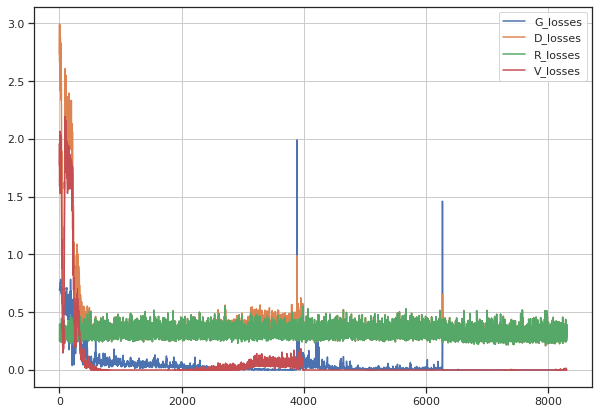

In [48]:
plt.figure(figsize=(10, 7))
plt.plot(losses_ed[0], label = 'G_losses')
plt.plot(losses_ed[1], label = 'D_losses')
plt.plot(losses_ed[2], label = 'R_losses')
plt.plot(losses_ed[3], label = 'V_losses')
plt.legend()
plt.grid()
plt.show()

### ssim

In [49]:
losses_ssim = train(loader = train_loader, 
                    gen = gen_ssim, 
                    disc = disc_ssim, 
                    criterion_gan = criterion_gan_ssim, 
                    G_opt = G_opt_ssim, 
                    D_opt = D_opt_ssim, 
                    model_verification = model_verification, 
                    criterion_verification = criterion_verification, 
                    criterion_regulator = SSIM_1d_conv,
                    save_PATH = 'trained_models/gan_ssim.pt', 
                    lr = lr, 
                    batch_size = batch_size, 
                    num_epochs = num_epochs, 
                    n_noise = n_noise, 
                    n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 0.6309, Loss G: 0.2454, Loss V: 0.0000, Loss R: 0.5107
Epoch [10/100] Batch 82/83 Loss D: 0.5988, Loss G: 0.0126, Loss V: 0.0348, Loss R: 0.5632
Epoch [20/100] Batch 82/83 Loss D: 2.4191, Loss G: 0.0037, Loss V: 1.6433, Loss R: 0.7757
Epoch [30/100] Batch 82/83 Loss D: 0.7383, Loss G: 0.0011, Loss V: 1.0536, Loss R: -0.3153
Epoch [40/100] Batch 82/83 Loss D: 2.0800, Loss G: 0.0007, Loss V: 0.5199, Loss R: 1.5601
Epoch [50/100] Batch 82/83 Loss D: 1.2330, Loss G: 0.0022, Loss V: 0.0000, Loss R: 1.2328
Epoch [60/100] Batch 82/83 Loss D: 0.4835, Loss G: 0.0027, Loss V: 0.0000, Loss R: 0.4834
Epoch [70/100] Batch 82/83 Loss D: 0.4923, Loss G: 0.0032, Loss V: 0.0000, Loss R: 0.4921
Epoch [80/100] Batch 82/83 Loss D: -1.2477, Loss G: 0.0025, Loss V: 0.0000, Loss R: -1.2477
Epoch [90/100] Batch 82/83 Loss D: 1.4408, Loss G: 0.0034, Loss V: 0.0000, Loss R: 1.4408


In [50]:
gen_ssim = Generator().to(device)
disc_ssim = Discriminator().to(device)

checkpoint_ssim = torch.load('trained_models/gan_ssim.pt')

gen_ssim.load_state_dict(checkpoint_ssim['gen_state_dict'])
disc_ssim.load_state_dict(checkpoint_ssim['disc_state_dict'])
de_ident_rate_ssim = checkpoint_ssim['de_ident_rate']
str_simil_ssim = checkpoint_ssim['str_simil']

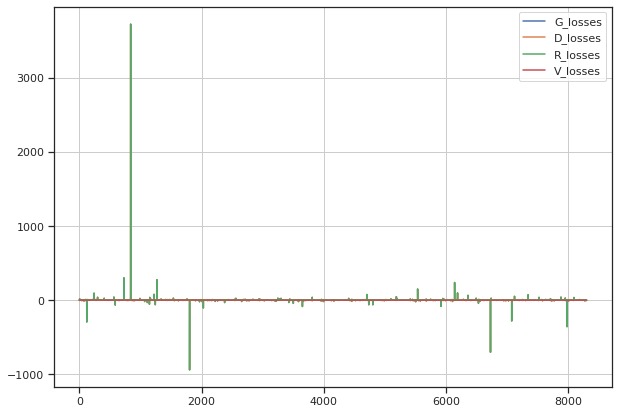

In [51]:
plt.figure(figsize=(10, 7))
plt.plot(losses_ssim[0], label = 'G_losses')
plt.plot(losses_ssim[1], label = 'D_losses')
plt.plot(losses_ssim[2], label = 'R_losses')
plt.plot(losses_ssim[3], label = 'V_losses')
plt.legend()
plt.grid()
plt.show()

### Figure

In [52]:
reg_names = ['Mean_similarity_loss', 
             'Root_mean_square_similarity_loss', 
             'Coisine_between_angles_loss', 
             'Pearson_corr_funct_loss', 
             'Eucledian_distance_loss', 
             'SSIM_1d_conv']

regul_loss_dict = dict.fromkeys(reg_names, [])
regul_loss_list = [Mean_similarity_loss, 
                   Root_mean_square_similarity_loss, 
                   Coisine_between_angles_loss,
                   Pearson_corr_funct_loss, 
                   Eucledian_distance_loss, 
                   SSIM_1d_conv]


In [53]:
de_ident_rate_ms

0.963003396987915

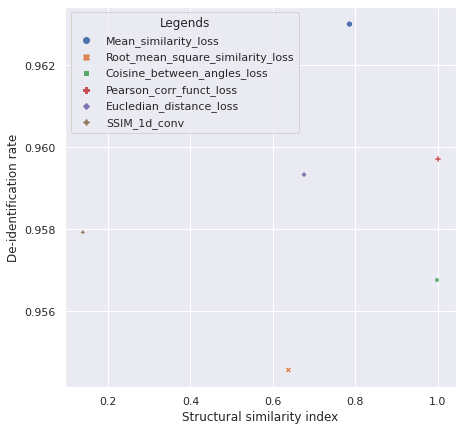

In [55]:
sns.set_theme()
data = pd.DataFrame({
    'Structural similarity index': [str_simil_ms, 
                                    str_simil_rms, 
                                    str_simil_cba, 
                                    str_simil_pcf, 
                                    str_simil_ed, 
                                    str_simil_ssim],
    'De-identification rate': [de_ident_rate_ms, 
                               de_ident_rate_rms, 
                               de_ident_rate_cba, 
                               de_ident_rate_pcf, 
                               de_ident_rate_ed, 
                               de_ident_rate_ssim],
    'Legends': reg_names})

plt.figure(figsize = (7, 7))
sns.scatterplot(data=data, x="Structural similarity index", 
                y="De-identification rate", 
                hue = 'Legends', 
                style="Legends",
                legend='brief');
plt.savefig('De_iden_vs_structural_simil')


## test

In [56]:
scales_vectors = np.array([torch_dataset.feature_scales[f] for f in range(len(required_params))])

sparse_rate = torch_dataset.sparse_rate
print('sparse_rate', sparse_rate)
L = 64
print('L', L)
# window = L * sparse_rate
window = 64
print('window', window)
step = 4
print('step', step)

sparse_rate 1
L 64
window 64
step 4


In [57]:
test_well = wells[22]
test_well

'well_17.json'

In [58]:
X_test = pd.DataFrame(logs[22]['data'], columns=[x['name'] for x in logs[22]['curves']])
X_test = X_test[required_params]
X_test = X_test.drop_duplicates()

In [59]:
y_name = 'DEPTH'
# X_test

In [60]:
def apply_window_transform(x, s, latent_noise_rate=0):
    x = x[np.arange(0, len(x), sparse_rate), :]
    mean_x = x.mean(axis=0)
    x = (x - mean_x)/s
    with torch.no_grad():
        x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
        z = gen_ssim(x.transpose(1, 2))
    
    return z.transpose(1, 2)[0].cpu().data.numpy()*s + mean_x, z.transpose(1, 2)[0].cpu().data.numpy()

In [61]:
def apply_rolling_transform(X, w, scales, step=12):
    Z = []
    
    for i in tqdm(range(0, len(X) - w, step)):
        Z.append(apply_window_transform(X[i: i+w], scales))
        
    return Z

In [62]:
Z = apply_rolling_transform(X_test[required_params].values, window, scales_vectors, step)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:03<00:00, 278.20it/s]


837it [00:00, 179884.84it/s]
/tmp/ipykernel_12997/717006292.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 180504.52it/s]
/tmp/ipykernel_12997/717006292.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 171100.13it/s]
/tmp/ipykernel_12997/717006292.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 185482.77it/s]
/tmp/ipykernel_12997/717006292.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 185238.10it/s]
/tmp/ipykernel_12997/717006292.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)


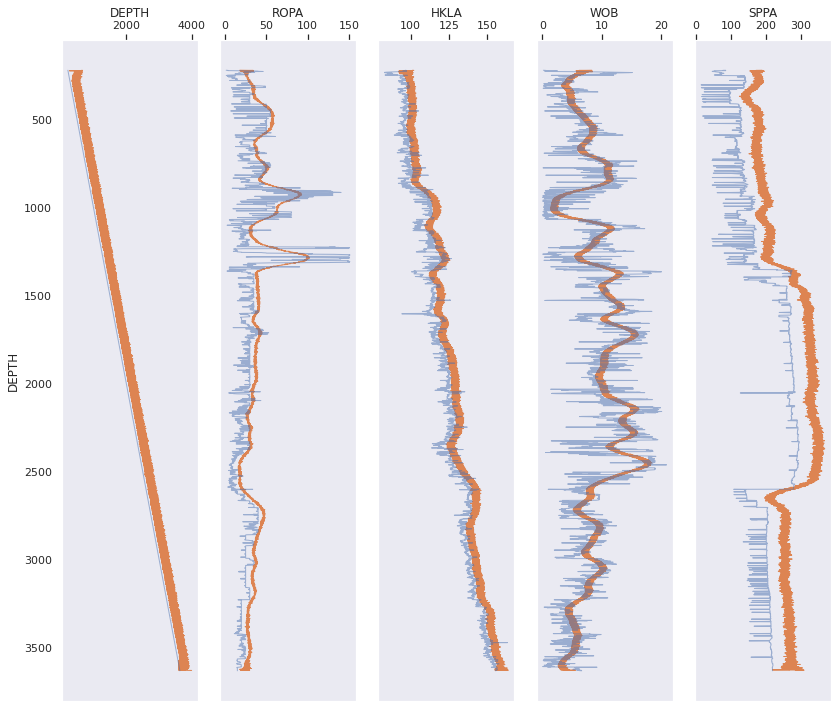

In [63]:
original = []
generated = []

t = X_test[y_name].astype(float).values
plt.figure(figsize=(14, 10))
for i, curve_name in enumerate(required_params):
    plt.subplot(1, len(df.columns) - 1, i + 1)
#     for zi, x in tqdm(enumerate(range(0, len(df_well) - window, step))):
#         plt.plot(Z[zi][0][:, i], t[np.arange(x, x+window, sparse_rate)], color='C1', alpha=0.5, lw=0.5)

    zis = range(0, len(X_test) - window, step)
    A = np.zeros((len(zis), len(X_test))) * np.nan
    for zi, x in tqdm(enumerate(zis)):
        A[zi, np.arange(x, x+window, sparse_rate)] = Z[zi][0][:, i]
    
    A = np.nanmean(A, axis=0)
    not_nan_inds = np.where(~np.isnan(A))[0]
    
    original.append(X_test[curve_name].astype(float).values)
    generated.append(A[not_nan_inds])
    
    plt.plot(A[not_nan_inds], t[not_nan_inds], color='C1', lw=1)
    plt.plot(X_test[curve_name].astype(float).values, t, lw=1, color='C0', alpha=0.5)
    plt.grid()
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    if i > 0: axis.set_yticklabels([])

    if i == 0:
        plt.ylabel(f'{y_name}')
    plt.xlabel(f'{curve_name}')

plt.tight_layout()
# plt.save('')

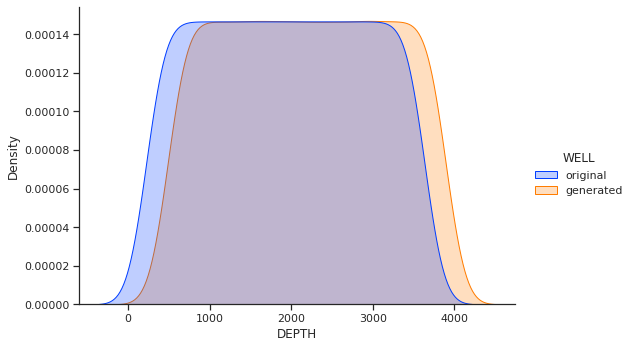

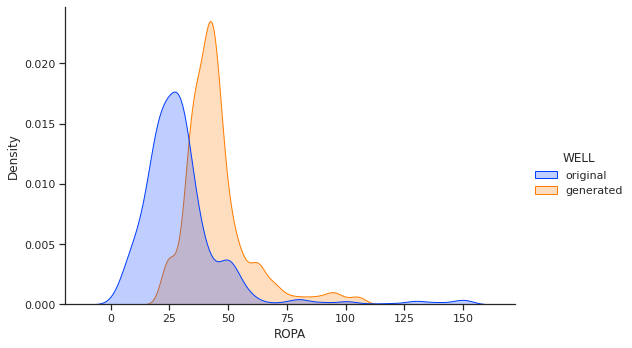

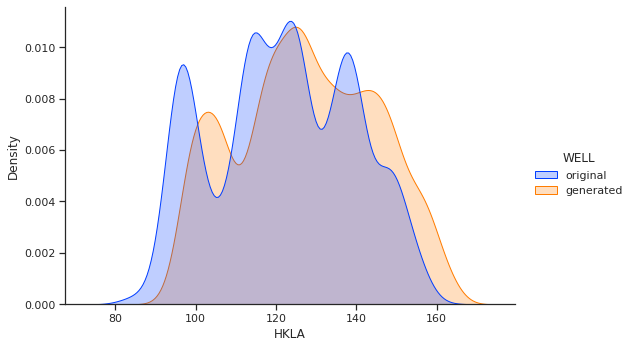

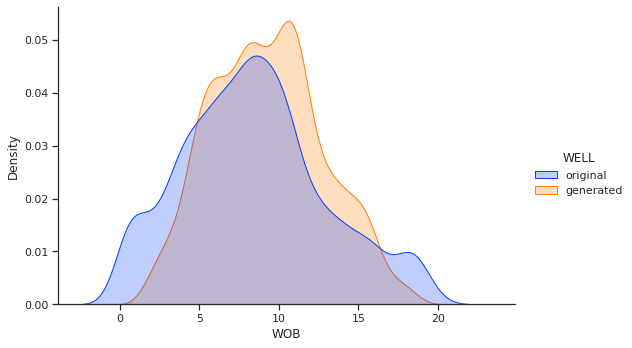

In [58]:
for i in required_params[:-1]:
    sns.displot(data=df_some, 
            x=i, hue='WELL', kind='kde',
            fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5
               )